In [125]:
#imports

import pandas as pd
import numpy as np
import json
import matplotlib
%matplotlib inline

import joblib

## Problem Overview

In this project, we were tasked with making a model to predict performance on assessements in the PBS Kids learning mobile application based on logged application data.

# Outline

- Begin the process by taking a look at the *training* data basic features:
    - Event code counts
    - unique installations
    - unique sessions
- Add another layer by looking at grouped features:
    - group by installation id: game time, event code counts,
    - group by session within an installation
- Compare train and test data as a reality check
- Unpack inner data
    - event data
    - specs args
- Join the train_labels to train data
- Set up an initial naive baseline
    - feature engineering
    - K Nearest Neighbors
- Improve the model by trying alternative methods
    - CatBoost
    - Light GBM Regression

In [2]:
#Read in training data first
train = pd.read_csv("../DSB2019/data-science-bowl-2019/train.csv")

In [3]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


Taking a brief look at some example observations we see that each represents information related to an "event". We get event data in an internal object as well as event meta data such as ID, related installation ID (normally one user), timestamp, and where they are in the application (title, world, type). 

In [4]:
train.shape

(11341042, 11)

In order to explore the features more easily let's sample a small piece of the total. Total shape has over 11 million observations.
It's also worth noting that some of the installation ids in the training data don't contain assessments so we can eliminate those as they are not useful for training.

In [6]:
hasAssessmentIds = train[train["type"] == "Assessment"].loc[:,'installation_id'].drop_duplicates()
useful_train = pd.merge(train, hasAssessmentIds, on="installation_id", how="inner")
del train

In [7]:
useful_train.shape

(8294138, 11)

In [58]:
train_sample = useful_train.sample(1000000)

Let's list out the columns we're going to need to look at for each observation.

In [9]:
train_sample.columns

Index(['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title',
       'type', 'world'],
      dtype='object')

It seems like it could be useful to categorize different observations in the data. Event codes could represent some of these differences.

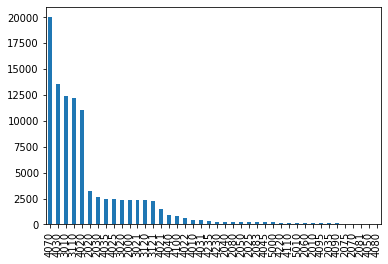

In [10]:
train_sample["event_code"].value_counts().plot.bar()

In [11]:
train_sample.groupby("installation_id").sum()

,event_count,event_code,game_time
installation_id,,,
0006a69f,2418,155838,2994032
0006c192,2466,84224,2368500
00129856,1363,49469,1805639
001d0ed0,734,35594,815923
00225f67,597,28540,571335
...,...,...,...
ff9715db,1872,96986,2024098
ffc90c32,557,55851,632449
ffd2871d,3024,114203,5537152


This tells us there are about 4000 installation ids in the sample and gives us information about total game time.

In [12]:
train_sample.groupby("game_session").sum()

,event_count,event_code,game_time
game_session,,,
000050630c4b081b,3,2060,4804
00020f3bd042b3f0,2,4010,2230
00030865234e6b3d,27,4020,36526
000319989d08f8aa,494,9160,745700
0007729b666af371,167,4070,194174
...,...,...,...
fffc036248965403,124,4070,93425
fffc152654849cbe,120,7210,125564
fffc54cfd9f4d7b2,37,3110,49684


Not sure game session ids are telling me what I thought they were here. They don't seem to overlap much, some sessions only contining 1 obseravtion.

Let's take a deeper look at a set of events for a single ID.

In [13]:
single_id = train_sample.query('installation_id=="0006a69f"')
single_id.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
819,28f975ea,80d34a30c2998653,2019-08-06T05:25:31.088Z,"{""distance"":4,""dinosaur"":""don"",""target_distanc...",0006a69f,125,4020,155126,Air Show,Game,TREETOPCITY
471,02a42007,05921a6eb858eeba,2019-08-06T05:16:12.546Z,"{""rocket"":3,""coordinates"":{""x"":330,""y"":607,""st...",0006a69f,78,4030,81224,Fireworks (Activity),Activity,TREETOPCITY
3585,e9c52111,667e94bc234d1dbd,2019-08-29T16:26:04.802Z,"{""jar"":[{""color"":""blue"",""amount"":1},{""color"":""...",0006a69f,31,2030,46808,Bottle Filler (Activity),Activity,MAGMAPEAK
1515,6c517a88,cfc0fcbfcace6a52,2019-08-06T05:46:33.542Z,"{""coordinates"":{""x"":311,""y"":55,""stage_width"":1...",0006a69f,74,4070,93480,Dino Drink,Game,MAGMAPEAK
1764,363d3849,faed1805baea37b0,2019-08-06T17:46:05.315Z,"{""media_type"":""animation"",""total_duration"":410...",0006a69f,4,3010,4293,All Star Sorting,Game,TREETOPCITY


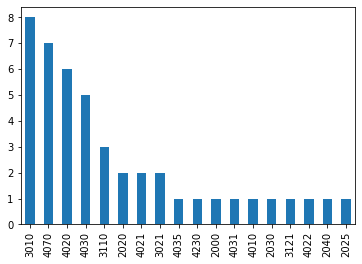

In [14]:
single_id["event_code"].value_counts().plot.bar()

In [15]:
#This user has 25 different game sessions
single_id["game_session"].value_counts().count()

25

In [16]:
single_id["type"].value_counts()

Game          28
Activity      15
Assessment     2
Name: type, dtype: int64

It might be interesting to compare some features in the train data to the test data, as a reality check that things are relatively similar.

In [20]:
test = pd.read_csv("../DSB2019/data-science-bowl-2019/test.csv")

In [21]:
test.shape

(1156414, 11)

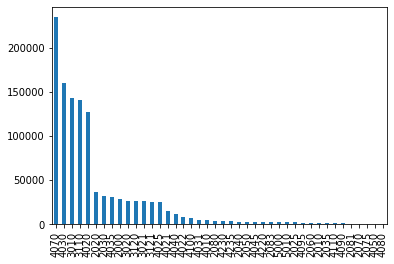

In [22]:
test["event_code"].value_counts().plot.bar()

Event code, at least, looks fairly similar. That's good!
Next, let's look at various other statistics.

In [23]:
display(train_sample["event_code"].nunique())
display(test["event_code"].nunique())

42

42

In [24]:
display(train_sample["event_id"].nunique())
display(test["event_id"].nunique())

358

365

In [25]:
display(train_sample["installation_id"].nunique())
display(test["installation_id"].nunique())

4070

1000

Unpack the inner data

In [26]:
# Code below based on code original written/published by Gabriel Preda
# on Kaggle, accessed Mon, 18 Nov, 2019
# https://www.kaggle.com/gpreda/2019-data-science-bowl-eda
extracted_event_data = pd.io.json.json_normalize(train_sample.event_data.apply(json.loads))

In [27]:
extracted_event_data.shape

(100000, 135)

In [28]:
extracted_event_data.head()

,description,identifier,media_type,duration,level,round,event_count,game_time,event_code,coordinates.x,...,bowls,bird_height,hats_placed,stage_number,tutorial_step,toy_earned,molds,dwell_time,tape_length,bug_length
0,Which pail is right for the chicken?,chicken_whichwater,animation,902.0,5.0,12.0,126,169840.0,3110,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,26,28093.0,4070,661.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tap the bucket that holds the least amount of ...,Dot_TapBucketLeast,audio,NaN,NaN,NaN,24,26100.0,3010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Amazing!,Dot_Amazing,audio,1132.0,NaN,NaN,20,25383.0,3110,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Three!,sid_3,animation,467.0,NaN,NaN,100,67773.0,3110,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


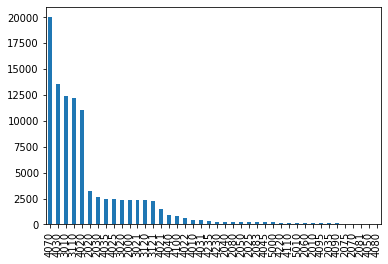

In [29]:
extracted_event_data["event_code"].value_counts().plot.bar()

Join the labels to the training set.

In [31]:
train_labels = pd.read_csv("../DSB2019/data-science-bowl-2019/train_labels.csv")

In [59]:
# Code below based on code original written/published by Gabriel Preda
# on Kaggle, accessed Mon, 18 Nov, 2019
# https://www.kaggle.com/gpreda/2019-data-science-bowl-eda

numerical_columns = ['game_time']
categorical_columns = ['type', 'world']

comp_train_sample = pd.DataFrame({'installation_id': train_sample['installation_id'].unique()})
comp_train_sample.set_index('installation_id', inplace = True)

In [60]:
def get_numeric_columns(df, column):
    df = df.groupby('installation_id').agg({f'{column}': ['mean', 'sum', 'min', 'max', 'std', 'skew']})
    df[column].fillna(df[column].mean(), inplace = True)
    df.columns = [f'{column}_mean', f'{column}_sum', f'{column}_min', f'{column}_max', f'{column}_std', f'{column}_skew']
    return df

In [61]:
for i in numerical_columns:
    comp_train_sample = comp_train_sample.merge(get_numeric_columns(train_sample, i), left_index = True, right_index = True)

/home/maxwell/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [62]:
# get the mode of the title
labels_map = dict(train_labels.groupby('title')['accuracy_group'].agg(lambda x:x.value_counts().index[0]))
# merge target
labels = train_labels.loc[:, ['installation_id', 'title', 'accuracy_group']]
# replace title with the mode
labels['title'] = labels['title'].map(labels_map)
# join train with labels
comp_train_sample = labels.merge(comp_train_sample, on = 'installation_id', how = 'left')
print('We have {} training rows'.format(comp_train_sample.shape[0]))

We have 17690 training rows


This gives us the number of rows we can actually use in a future model.

## Let's establish a naive baseline model to work from

In [63]:
# Code below based on code original written/published by Massoud Hosseinali
# on Kaggle, accessed 20 Nov, 2019
# https://www.kaggle.com/mhviraf/a-baseline-for-dsb-2019
submission = pd.read_csv("../DSB2019/data-science-bowl-2019/sample_submission.csv")

In [64]:
labels_map = dict(train_labels.groupby('title')['accuracy_group'].agg(lambda x:x.value_counts().index[0])) # get the mode
labels_map

{'Bird Measurer (Assessment)': 0,
 'Cart Balancer (Assessment)': 3,
 'Cauldron Filler (Assessment)': 3,
 'Chest Sorter (Assessment)': 0,
 'Mushroom Sorter (Assessment)': 3}

In [65]:
submission['accuracy_group'] = test.groupby('installation_id').last()['title'].map(labels_map).reset_index(drop=True)
submission.to_csv('submission.csv', index=None)
display(submission.shape)
submission.head()

(1000, 2)

,installation_id,accuracy_group
0,00abaee7,NaN
1,01242218,NaN
2,017c5718,NaN
3,01a44906,NaN
4,01bc6cb6,NaN


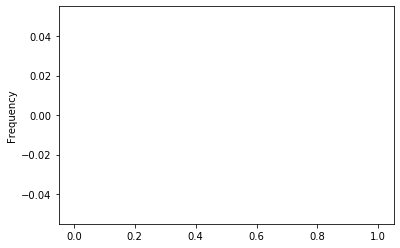

In [66]:
submission['accuracy_group'].plot(kind='hist')

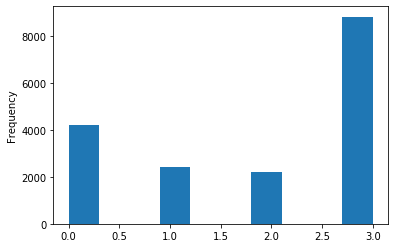

In [67]:
train_labels['accuracy_group'].plot(kind='hist')

## Feature Engineering

In order to do any modeling, the data needs to be preprocessed and prepared. I have chosen to do a categorical aggregation of the data into summary statistics grouped by installion id (user) and accumulated for each session prior to an assessment.

In [68]:
# Code below based on code original written/published by Massoud Hosseinali
# on Kaggle, accessed 13 Dec, 2019
# https://www.kaggle.com/mhviraf/a-new-baseline-for-dsb-2019-catboost-model

#first we need to make a mapping to the proper event code for a completion of each event

#list all activity titles
list_of_user_activities = list(set(train_sample['title'].value_counts().index).union(set(test['title'].value_counts().index)))
#map each activity to its integer index (very simple hash)
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))

# modify the df (essentially a rename)
train_sample['title'] = train_sample['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)

#assessment successful event, or win code, is 4100 for most
#assesments but 4110 for the final
#make a mapping for this 
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

In [69]:
#convert the time data
train_sample['timestamp'] = pd.to_datetime(train_sample['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [83]:
#Make some dictionaries of unique event values to track their aggregrates
list_of_event_code = list(set(train_sample['event_code'].unique()).union(set(test['event_code'].unique())))
list_of_event_id = list(set(train_sample['event_id'].unique()).union(set(test['event_id'].unique())))
activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))

In [101]:
from collections import Counter

# create a function to summarize the data in each session

def agg_data(data, test_set=False):
    
    activityData = []
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_incorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    durations = []
    last_activity = 0
    
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    
    for i, session in data.groupby('game_session', sort=False):
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        
        #if we find an assessment and a session
        #look at assessment data
        if (session_type == 'Assessment') & (test_set or len(session) > 1):
            
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            #check true or false by searching json event data str
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            
            features = user_activities_count.copy()
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            
            #baseline the number of attempts
            features['session_title'] = session['title'].iloc[0] 
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_incorrect_attempts'] = accumulated_incorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_incorrect_attempts += false_attempts
            
            #recalc average of the duration
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)
            
            #compute accuracy as described in the competition
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
                
            
            features.update(accuracy_groups)
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            features['accumulated_actions'] = accumulated_actions
            accumulated_accuracy_group += features['accuracy_group']
            accuracy_groups[features['accuracy_group']] += 1
                
            if test_set or true_attempts+false_attempts > 0:
                activityData.append(features)
                
            counter += 1
            
        # count how many actions in each event_code so far by type
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        
        # sum total actions for a session
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
                
    return activityData[-1] if test_set else activityData

In [102]:
#compile data for each installation id by running above function
compiled_data = []
for i, (ins_id, data) in enumerate(train_sample.groupby('installation_id', sort=False)):
    compiled_data += agg_data(data)

new_train_sample = pd.DataFrame(compiled_data)
del compiled_data
new_train_sample

,Clip,Activity,Assessment,Game,2050,4100,2060,4110,2070,2075,...,Egg Dropper (Activity),Tree Top City - Level 2,session_title,accumulated_correct_attempts,accumulated_incorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,accumulated_accuracy_group,accumulated_actions
0,0,1,2,1,0,0,0,0,0,0,...,0,0,81,0,0,3.0,0.00,0,0.00,35
1,0,1,0,0,0,0,0,0,0,0,...,0,0,81,0,0,0.0,0.00,3,0.00,16
2,0,2,1,2,0,0,0,1,0,0,...,0,0,64,1,0,86379.0,1.00,0,3.00,65
3,1,5,2,13,2,1,1,1,2,0,...,0,0,81,1,1,43199.0,0.50,0,1.50,261
4,1,20,4,24,5,4,2,3,2,0,...,0,0,76,1,3,64794.5,0.25,0,0.75,603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3974,0,1,0,0,0,0,0,0,0,0,...,0,0,82,0,0,0.0,0.00,3,0.00,15
3975,0,0,0,0,0,0,0,0,0,0,...,0,0,29,0,0,0.0,0.00,0,0.00,0
3976,0,0,1,0,0,1,0,0,0,0,...,0,0,29,0,1,7.0,0.00,3,0.00,6
3977,0,0,0,0,0,0,0,0,0,0,...,0,0,76,0,0,0.0,0.00,3,0.00,0


In [103]:
all_features = [x for x in new_train_sample.columns if x not in ['accuracy_group']]
X, y = new_train_sample[all_features], new_train_sample['accuracy_group']
X.shape

(3979, 512)

Fit and predict based on the model:

In [104]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

oof = np.zeros(len(X))

NFOLDS = 2
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=2019)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    currX = X.loc[trn_idx, all_features]
    scaler = StandardScaler()
    scaler.fit(currX)
    currX_sc = scaler.transform(currX)
    
    # K-Nearest Neighbors Model
    model = KNeighborsClassifier(n_neighbors=4)
    model.fit(currX_sc, y.loc[trn_idx])
    oof[test_idx] = model.predict(X.loc[test_idx,all_features])

print(pd.Series(oof).value_counts())
print(pd.Series(y).value_counts())
display(accuracy_score(y, oof))
cohen_kappa_score(y, oof, weights="quadratic")

0.0    3745
3.0     229
2.0       5
dtype: int64
0    2414
3    1412
2     127
1      26
Name: accuracy_group, dtype: int64


0.591605931138477

0.0007181355734393602

Looks like this model is pretty poor because the features are not really set up properly for a KNN classification. Let's move on to some better modeling.

# Model Improvements

## Cat Boost
Code below based on code original written/published by Massoud Hosseinali
on Kaggle, accessed 13 Dec, 2019
https://www.kaggle.com/mhviraf/a-new-baseline-for-dsb-2019-catboost-model

Use our previously aggregated features to fit a category boosting model.

In [105]:
from catboost import CatBoostClassifier

In [106]:
cat_features = ['session_title']

In [107]:
def make_classifier():
    return CatBoostClassifier(loss_function='MultiClass',
            task_type="CPU",
            learning_rate=0.01,
            iterations=2000,
            od_type="Iter",
            early_stopping_rounds=500,
            random_seed=1001);

In [108]:
cb_oof = np.zeros(len(X))
folds = KFold(n_splits=5, shuffle=True, random_state=1001)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    clf = make_classifier()
    clf.fit(X.loc[trn_idx, all_features], y.loc[trn_idx], eval_set=(X.loc[test_idx, all_features], y.loc[test_idx]),
                          use_best_model=True, verbose = False, cat_features=cat_features)

    cb_oof[test_idx] = clf.predict(X.loc[test_idx, all_features]).reshape(len(test_idx))
    
cohen_kappa_score(y, cb_oof, weights="quadratic")

0.40278917827350325

As we can see this model gives a much better result due to better use of the features produced earlier. It uses a gradient boosting on decision trees technique to achieve these results.
I found this article particularly helpful to understanding how it performs compared to other methods. 

https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

## Regression model

Let's test one of the regression options to see how it performs. There is a fair amount of numerical data so it could be decent.

Code below based on code original written/published by Andrew Lukyanenko
on Kaggle, accessed 13 Dec, 2019
https://www.kaggle.com/artgor/quick-and-dirty-regression

In [112]:
import lightgbm as lgb

In [115]:
#specify params

params = {  
            'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100,
            'eval_metric': 'cappa'
          }

In [116]:
lgb_oof = np.zeros(len(X))
folds = KFold(n_splits=5, shuffle=True, random_state=1001)

In [118]:
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    reg_model = lgb.LGBMRegressor()
    reg_model.set_params(**params)
    
    reg_model.fit(X.loc[trn_idx, all_features], y.loc[trn_idx], eval_set=(X.loc[test_idx, all_features], y.loc[test_idx]),
                    verbose = False, early_stopping_rounds=params['early_stopping_rounds'])

    lgb_oof[test_idx] = reg_model.predict(X.loc[test_idx, all_features]).reshape(len(test_idx))

In [122]:
#convert to kappa scoreable resuls
lgb_oof[lgb_oof <= 1.12232214] = 0
lgb_oof[np.where(np.logical_and(lgb_oof > 1.12232214, lgb_oof <= 1.73925866))] = 1
lgb_oof[np.where(np.logical_and(lgb_oof > 1.73925866, lgb_oof <= 2.22506454))] = 2
lgb_oof[lgb_oof > 2.22506454] = 3

In [123]:
cohen_kappa_score(y, lgb_oof, weights="quadratic")

0.33278018643269935

As we can see this model gives a somewhat worse result as compared to CatBoost due to worse use of the categorical features.

## Reflection

Data Science is an interative process full of trial and error exploration. This project gave me great insight into the process of tuning and retuning features and testing different types of modeling to predict an outcome. I'm looking forward to rerunning on the entire data set in order to make a submission to the competition.